In [17]:
print("hello world")

hello world


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [19]:
import os
import pandas as pd

# set the directory path where the csv files are located
dir_path = './'

# get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# create an empty dictionary to store the dataframes
dfs = {}

# loop through each csv file and read it into a dataframe
for file in csv_files:
    # get the name of the file without the extension
    name = file.split('.')[0]
    # read the csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))
    # add the dataframe to the dictionary with the file name as the key
    dfs[name] = df

print(dfs['weather_data'].head())
dfs['sensor_readings'].head()

      timestamp  Barometric_Pressure   Humidity  Temperature  Wind_Direction  \
0  4/18/23 0:00           827.064433  32.200298    10.971487      306.335774   
1  4/18/23 0:00           827.073897  32.200297    11.116626      311.523873   
2  4/18/23 0:00           827.301068  32.138772    10.861056      324.694315   
3  4/18/23 0:00           827.073913  32.100913    11.012511      316.473451   
4  4/18/23 0:00           827.092847  31.999946    10.969914      315.187093   

   Wind_Speed  
0    1.836502  
1    1.875021  
2    1.966547  
3    2.060548  
4    1.947818  


,Unnamed: 0,time,111111_ 40.595561_-105.14055_3,111111_ 40.596108_-105.140583_4,111111_40.595556_-105.140069_2,111111_40.596114_-105.140075_1,222222_ 40.596108_-105.140583_4,222222_40.595556_-105.140069_2,222222_40.595561_-105.14055_3,222222_40.596114_-105.140075_1,...,444444_40.595881_-105.139686_1,444444_40.595947_-105.139833_4,555555_40.595542_-105.139211_2,555555_40.595547_-105.139714_3,555555_40.596089_-105.139144_1,555555_40.596097_-105.139678_4,666666_40.595542_-105.139211_2,666666_40.595547_-105.139714_3,666666_40.596089_-105.139144_1,666666_40.596097_-105.139678_4
0,1,1681776002,1030.0,1049.0,1166.0,964.0,1023.0,1090.5,1039.5,1153.0,...,1120.0,735.0,1088.0,991.5,931.0,1040.0,1040.0,1111.0,1080.0,1089.0
1,2,1681776003,1033.0,1051.0,1163.0,974.0,993.0,1095.0,1044.0,1152.0,...,1104.5,765.0,1090.0,984.0,928.5,1043.0,1052.0,1105.5,1075.0,1095.0
2,3,1681776004,1022.0,1051.0,1160.0,975.5,974.0,1081.0,1049.0,1133.0,...,1089.0,762.0,1095.0,993.0,926.0,1039.0,1033.0,1100.0,1021.0,1093.0
3,4,1681776005,1034.0,1050.0,1165.0,977.0,988.0,1084.0,1019.0,1128.0,...,1082.0,762.0,1100.0,999.0,929.0,1047.5,1014.0,1107.0,1059.5,1110.0
4,5,1681776006,1037.5,1049.0,1155.0,977.0,971.0,1084.0,1027.0,1144.0,...,1070.0,763.0,1100.0,1004.5,944.0,1056.0,1019.0,1098.0,1098.0,1107.5


Shape of the dataset:  (86401, 6)


C:\Users\Rohan\AppData\Local\Temp\ipykernel_143924\3124946671.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = curr_df.corr()


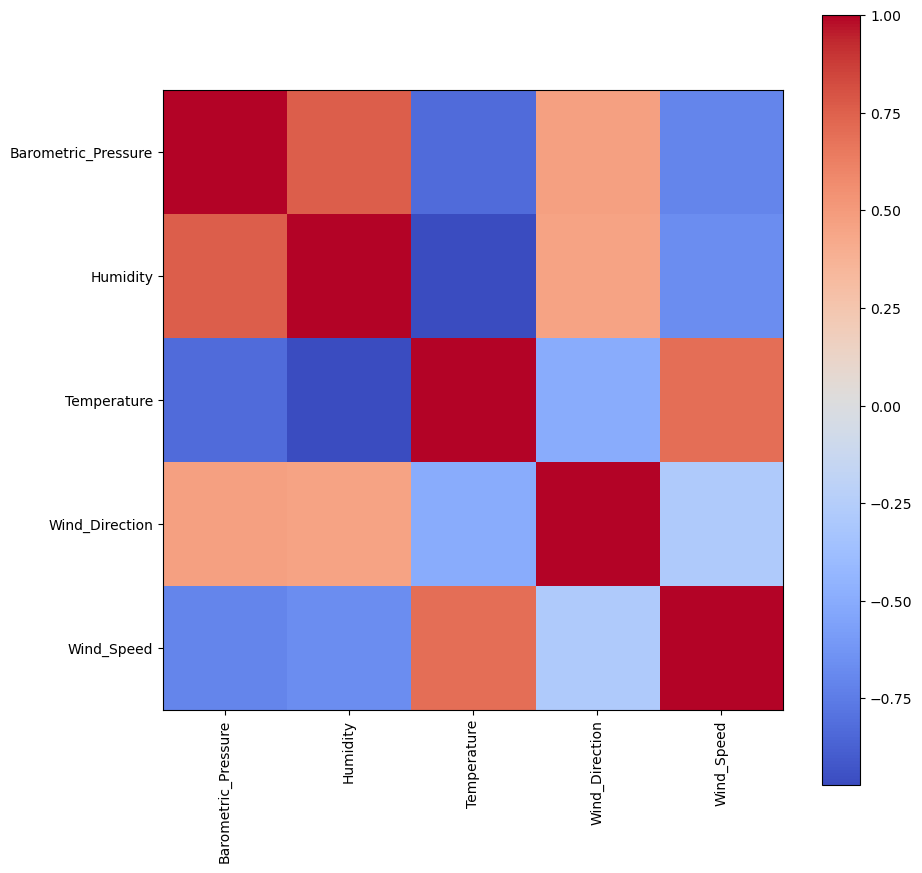

In [20]:
# Print the shape of the dataset
weather_data = dfs['weather_data']
sensor_readings = dfs['sensor_readings']
leak_locations_and_rate = dfs['leak_locations_and_rate']
curr_df = weather_data
print("Shape of the dataset: ", curr_df.shape)
# Get the correlation of the features
corr = curr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10,10))
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.show()

In [21]:
leak_locations_and_rate.head()

,EventID,NumberSourcesLeaking,LeakPointId,Latitude,Longitude,EmissionCategory,UTCStart,UTCEnd,Duration,LeakRate,BFT,tStart,tEnd
0,40,2,4T-31,40.595830,-105.139824,Fugitive,2023-04-18_00:00:35.000000,2023-04-18_00:15:35.000000,900,36.636270,ReferenceMeteredEvent,1681776035,1681776935
1,40,2,5S-26,40.595924,-105.139390,Fugitive,2023-04-18_00:00:35.000000,2023-04-18_00:15:35.000000,900,64.621765,ReferenceMeteredEvent,1681776035,1681776935
2,41,2,4W-27,40.595936,-105.140270,Fugitive,2023-04-18_00:15:35.000000,2023-04-18_01:00:35.000000,2700,55.385376,ReferenceMeteredEvent,1681776935,1681779635
3,41,2,4S-43,40.595642,-105.140350,Fugitive,2023-04-18_00:15:35.000000,2023-04-18_01:00:35.000000,2700,24.345577,ReferenceMeteredEvent,1681776935,1681779635
4,42,2,4T-31,40.595830,-105.139824,Fugitive,2023-04-18_00:15:35.000000,2023-04-18_00:45:35.000000,1800,36.636270,ReferenceMeteredEvent,1681776935,1681778735


In [22]:
sensor_readings.head()

,Unnamed: 0,time,111111_ 40.595561_-105.14055_3,111111_ 40.596108_-105.140583_4,111111_40.595556_-105.140069_2,111111_40.596114_-105.140075_1,222222_ 40.596108_-105.140583_4,222222_40.595556_-105.140069_2,222222_40.595561_-105.14055_3,222222_40.596114_-105.140075_1,...,444444_40.595881_-105.139686_1,444444_40.595947_-105.139833_4,555555_40.595542_-105.139211_2,555555_40.595547_-105.139714_3,555555_40.596089_-105.139144_1,555555_40.596097_-105.139678_4,666666_40.595542_-105.139211_2,666666_40.595547_-105.139714_3,666666_40.596089_-105.139144_1,666666_40.596097_-105.139678_4
0,1,1681776002,1030.0,1049.0,1166.0,964.0,1023.0,1090.5,1039.5,1153.0,...,1120.0,735.0,1088.0,991.5,931.0,1040.0,1040.0,1111.0,1080.0,1089.0
1,2,1681776003,1033.0,1051.0,1163.0,974.0,993.0,1095.0,1044.0,1152.0,...,1104.5,765.0,1090.0,984.0,928.5,1043.0,1052.0,1105.5,1075.0,1095.0
2,3,1681776004,1022.0,1051.0,1160.0,975.5,974.0,1081.0,1049.0,1133.0,...,1089.0,762.0,1095.0,993.0,926.0,1039.0,1033.0,1100.0,1021.0,1093.0
3,4,1681776005,1034.0,1050.0,1165.0,977.0,988.0,1084.0,1019.0,1128.0,...,1082.0,762.0,1100.0,999.0,929.0,1047.5,1014.0,1107.0,1059.5,1110.0
4,5,1681776006,1037.5,1049.0,1155.0,977.0,971.0,1084.0,1027.0,1144.0,...,1070.0,763.0,1100.0,1004.5,944.0,1056.0,1019.0,1098.0,1098.0,1107.5


In [23]:
time_classification_map = {}
for index, row in leak_locations_and_rate.iterrows():
    interval = (row['tStart'], row['tEnd'])
    time_classification_map[interval] = row

def get_leak_location_and_rate(time):
    for interval in time_classification_map:
        if time >= interval[0] and time <= interval[1]:
            return time_classification_map[interval]
    return None

In [36]:
# add columns for longitude, latitude, and number of leaks
sensor_readings = sensor_readings.assign(longitude=None, latitude=None, num_leaks=0)

# print the updated dataframe
for index, row in sensor_readings.iterrows():
    time = row['time']
    location_and_rate = get_leak_location_and_rate(time)
    if location_and_rate is not None:
        sensor_readings.at[index, 'longitude'] = location_and_rate['Longitude']
        sensor_readings.at[index, 'latitude'] = location_and_rate['Latitude']
        sensor_readings.at[index, 'num_leaks'] = location_and_rate['NumberSourcesLeaking']

In [38]:
sensor_readings.describe()

,Unnamed: 0,time,111111_ 40.595561_-105.14055_3,111111_ 40.596108_-105.140583_4,111111_40.595556_-105.140069_2,111111_40.596114_-105.140075_1,222222_ 40.596108_-105.140583_4,222222_40.595556_-105.140069_2,222222_40.595561_-105.14055_3,222222_40.596114_-105.140075_1,...,444444_40.595947_-105.139833_4,555555_40.595542_-105.139211_2,555555_40.595547_-105.139714_3,555555_40.596089_-105.139144_1,555555_40.596097_-105.139678_4,666666_40.595542_-105.139211_2,666666_40.595547_-105.139714_3,666666_40.596089_-105.139144_1,666666_40.596097_-105.139678_4,num_leaks
count,83413.000000,8.341300e+04,83413.000000,83413.000000,83413.000000,83413.000000,8.341300e+04,8.341300e+04,83413.000000,83413.000000,...,83413.000000,83413.000000,83413.000000,83413.000000,83413.000000,83413.000000,83413.000000,83413.000000,83413.000000,83413.000000
mean,41707.000000,1.681818e+09,981.245046,1031.140302,1159.154922,953.869109,9.720851e+02,1.170478e+03,1033.204956,1098.729718,...,892.585460,1158.560728,1008.238902,904.651427,1113.918862,1075.861808,1136.595746,1033.250303,1129.391737,0.576817
std,24079.403339,2.478513e+04,67.952264,66.103792,122.729737,94.060993,5.011513e+03,3.836117e+04,629.050694,112.426619,...,1198.197435,96.692921,100.934852,108.552279,97.508330,393.692215,103.736548,106.463880,85.912814,0.940460
min,1.000000,1.681776e+09,701.000000,755.000000,664.000000,611.000000,9.300000e+01,1.950000e+02,717.000000,110.000000,...,411.000000,841.000000,666.000000,617.000000,732.000000,682.000000,186.000000,630.000000,708.000000,0.000000
25%,20854.000000,1.681797e+09,947.000000,1004.000000,1112.500000,926.000000,9.150000e+02,9.990000e+02,994.000000,1057.000000,...,760.000000,1117.000000,974.857143,867.000000,1083.000000,1027.000000,1090.000000,997.500000,1090.500000,0.000000
50%,41707.000000,1.681818e+09,995.000000,1044.000000,1167.000000,965.000000,9.670000e+02,1.047000e+03,1044.000000,1118.000000,...,808.000000,1167.000000,1023.000000,903.000000,1123.000000,1079.000000,1152.000000,1052.000000,1150.612903,0.000000
75%,62560.000000,1.681839e+09,1021.500000,1069.000000,1205.000000,993.000000,1.004500e+03,1.084000e+03,1076.500000,1150.000000,...,837.000000,1203.000000,1054.000000,931.000000,1155.000000,1114.000000,1193.000000,1083.000000,1179.000000,1.000000
max,83413.000000,1.681862e+09,1745.000000,1701.000000,2649.000000,2184.000000,1.030022e+06,1.108021e+07,118023.000000,16379.000000,...,16392.000000,2899.000000,2755.000000,2632.000000,16392.000000,110084.000000,10351.000000,16379.000000,1682.000000,3.000000
